In [2]:
# Install the required packages
%pip install numpy
%pip install pandas
%pip install matplotlib
%pip install seaborn


[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
# typing imports and aliases

from typing import TypeAlias
from typing import Optional, Any
Number: TypeAlias = int | float

In [4]:
# import the required packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.axes as Axes
import seaborn as sns

In [5]:
# add utility functions from cohort and homework exercises

def normalize_z(array: np.ndarray, 
                columns_means: Optional[np.ndarray]=None, 
                columns_stds: Optional[np.ndarray]=None) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Normalize the input array using the Z-score normalization method.
    """
    if columns_means is None:
            columns_means = array.mean(axis=0)
    if columns_stds is None:
            columns_stds = array.std(axis=0)
    columns_means = np.array(columns_means)  # Convert to NumPy array
    columns_stds = np.array(columns_stds)    # Convert to NumPy array
    out = (array - columns_means) / columns_stds
    out = np.array(out)    # Convert to NumPy array
    return out, columns_means, columns_stds


def get_features_targets(df: pd.DataFrame, 
                         feature_names: list[str], 
                         target_names: list[str]) -> tuple[pd.DataFrame, pd.DataFrame]:
    """
    Extract the features and targets from the input DataFrame.
    """
    df_feature = df.loc[:, feature_names]
    df_target = df.loc[:, target_names]
    return df_feature, df_target

def prepare_feature(np_feature: np.ndarray) -> np.ndarray:
    """
    Add a column of ones to the input array, representing beta_0.
    """
    return np.concatenate((np.ones((np_feature.shape[0], 1)), np_feature), axis=1)

def predict_linreg(array_feature: np.ndarray, beta: np.ndarray, 
                   means: Optional[np.ndarray]=None, 
                   stds: Optional[np.ndarray]=None) -> np.ndarray:
    """
    Predict the target values using the linear regression model.
    """
    n,_,_ = normalize_z(array_feature, means, stds)
    X = prepare_feature(n)
    return calc_linreg(X, beta)

def calc_linreg(X: np.ndarray, beta: np.ndarray) -> np.ndarray:
    """
    Calculate the linear regression model using the input feature matrix and beta values.
    """
    return np.matmul(X, beta)

def split_data(df_feature: pd.DataFrame, 
               df_target: pd.DataFrame, 
               random_state: Optional[int]=None, 
               test_size: float=0.5) -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    """
    Split the input features and targets into training and testing sets.
    """
    row = len(df_feature)
    test = int(row*test_size)
    np.random.seed(random_state)
    test_index = np.random.choice(row, test, replace=False)
    
    df_feature_test = df_feature.iloc[test_index].reset_index(drop=True)
    df_target_test = df_target.iloc[test_index].reset_index(drop=True)
    
    df_feature_train = df_feature.drop(test_index,axis = 'index').reset_index(drop=True)
    df_target_train = df_target.drop(test_index,axis = 'index').reset_index(drop=True)
    return df_feature_train, df_feature_test, df_target_train, df_target_test
  
def r2_score(y: np.ndarray, ypred: np.ndarray) -> float:
    """
    Calculate the R-squared score of the model.
    """
    row = y.shape[0]
    mean = np.sum(y)/row
    tot = np.sum((y-mean)**2)
    res = np.sum((y-ypred)**2)
    return (1 - res/tot)

def mean_squared_error(target: np.ndarray, pred: np.ndarray) -> float:
    """
    Calculate the mean squared error of the model.
    """
    row = target.shape[0]
    return np.sum((target-pred)**2)/row


def mean_absolute_percentage_error(target: np.ndarray, pred: np.ndarray) -> float:
    """
    Calculate the mean absolute percentage error of the model.
    """
    row = target.shape[0]
    return np.sum(np.abs(target-pred)/target)/row

def compute_cost_linreg(X: np.ndarray, y: np.ndarray, beta: np.ndarray) -> np.ndarray:
    """
    Compute the cost of the linear regression model.
    """
    e = calc_linreg(X, beta) - y
    m = e.shape[0]
    J = (1/(2*m)) * np.matmul(np.transpose(e), e)
    return np.squeeze(J)

def gradient_descent_linreg(X: np.ndarray, y: np.ndarray, beta: np.ndarray, 
                            alpha: float, num_iters: int) -> tuple[np.ndarray, np.ndarray]:
    """
    Perform gradient descent to find the optimal beta values.
    """
    J_storage = []
    for i in range(num_iters):
        m = X.shape[0]
        J_storage.append(compute_cost_linreg(X, y, beta))
        y_hat = calc_linreg(X, beta)
        beta = beta - np.matmul((alpha * (1/m)) * np.transpose(X), (y_hat-y))
    return beta, np.array(J_storage)

class Regressor():
    def __init__(self, df: pd.DataFrame, feature_names: list[str], target_names: list[str], test_size: float = 0.2, random_state: Optional[int] = 69):
        df.reset_index(drop=True, inplace=True)
        self.df = df

        df_features, df_target = get_features_targets(
            self.df, feature_names, target_names)

        # split the dataset into training and testing sets
        df_features_train, df_features_test, df_target_train, df_target_test = split_data(
            df_features, df_target, random_state, test_size)

        self.df_features_train = df_features_train
        self.df_features_test = df_features_test
        self.df_target_train = df_target_train
        self.df_target_test = df_target_test

        # normalize the features
        np_features_train, means, stds = normalize_z(
            self.df_features_train.to_numpy())

        self.np_features_train = np_features_train
        self.means = means
        self.stds = stds
        self.beta = np.zeros((np_features_train.shape[1], 1))

    def fit(self, iterations: int = 1000, alpha: float = 0.01):

        # prepare the features
        X = prepare_feature(self.np_features_train)
        target = self.df_target_train.to_numpy()
        beta = np.zeros((X.shape[1], 1))
        beta, J_storage = gradient_descent_linreg(
            X, target, beta, alpha, iterations)

        self.beta = beta

        return beta, J_storage

    def score(self):
        ypred = predict_linreg(
            self.df_features_test.to_numpy(), self.beta, self.means, self.stds)
        yactual = self.df_target_test.to_numpy()
        r2 = r2_score(yactual, ypred)
        mse = mean_squared_error(yactual, ypred)
        mape = mean_absolute_percentage_error(yactual, ypred)
        self.r2 = r2
        self.mse = mse
        self.mape = mape
        return {
            'r2': r2,
            'mse': mse,
            'mape': mape
        }
    
    def predict(self, features: np.ndarray) -> np.ndarray:
        return predict_linreg(features, self.beta, self.means, self.stds)


In [6]:
# import the dataset from csv file
df = pd.read_csv('./data/Agrofood_co2_emission.csv')

df.describe()

,Year,Savanna fires,Forest fires,Crop Residues,Rice Cultivation,Drained organic soils (CO2),Pesticides Manufacturing,Food Transport,Forestland,Net Forest conversion,...,Manure Management,Fires in organic soils,Fires in humid tropical forests,On-farm energy use,Rural population,Urban population,Total Population - Male,Total Population - Female,total_emission,Average Temperature °C
count,6965.000000,6934.000000,6872.000000,5576.000000,6965.000000,6965.000000,6965.000000,6965.000000,6472.000000,6.472000e+03,...,6037.000000,6965.000000,6810.000000,6009.000000,6.965000e+03,6.965000e+03,6.965000e+03,6.965000e+03,6.965000e+03,6965.000000
mean,2005.124910,1188.390893,919.302167,998.706309,4259.666673,3503.228636,333.418393,1939.581760,-17828.285678,1.760564e+04,...,2263.344946,1210.315532,668.452931,3008.982252,1.785774e+07,1.693230e+07,1.761963e+07,1.732447e+07,6.409124e+04,0.872989
std,8.894665,5246.287783,3720.078752,3700.345330,17613.825187,15861.445678,1429.159367,5616.748808,81832.210543,1.011575e+05,...,7980.542461,22669.847760,3264.879486,12637.864430,8.901521e+07,6.574362e+07,7.603993e+07,7.251711e+07,2.283130e+05,0.555930
min,1990.000000,0.000000,0.000000,0.000200,0.000000,0.000000,0.000000,0.000100,-797183.079000,0.000000e+00,...,0.432900,0.000000,0.000000,0.031900,0.000000e+00,0.000000e+00,2.500000e+02,2.700000e+02,-3.918841e+05,-1.415833
25%,1997.000000,0.000000,0.000000,11.006525,181.260800,0.000000,6.000000,27.958600,-2848.350000,0.000000e+00,...,37.632100,0.000000,0.000000,13.291900,9.731100e+04,2.173860e+05,2.013260e+05,2.078900e+05,5.221244e+03,0.511333
50%,2005.000000,1.651850,0.517900,103.698200,534.817400,0.000000,13.000000,204.962800,-62.920000,4.444000e+01,...,269.856300,0.000000,0.000000,141.096300,1.595322e+06,2.357581e+06,2.469660e+06,2.444135e+06,1.214765e+04,0.834300
75%,2013.000000,111.081400,64.950775,377.640975,1536.640000,690.408800,116.325487,1207.000900,0.000000,4.701746e+03,...,1126.818900,0.000000,9.577875,1136.925400,8.177340e+06,8.277123e+06,9.075924e+06,9.112588e+06,3.513973e+04,1.206750
max,2020.000000,114616.401100,52227.630600,33490.074100,164915.255600,241025.069600,16459.000000,67945.765000,171121.076000,1.605106e+06,...,70592.646500,991717.543100,51771.256800,248879.176900,9.000991e+08,9.020778e+08,7.435866e+08,7.133419e+08,3.115114e+06,3.558083


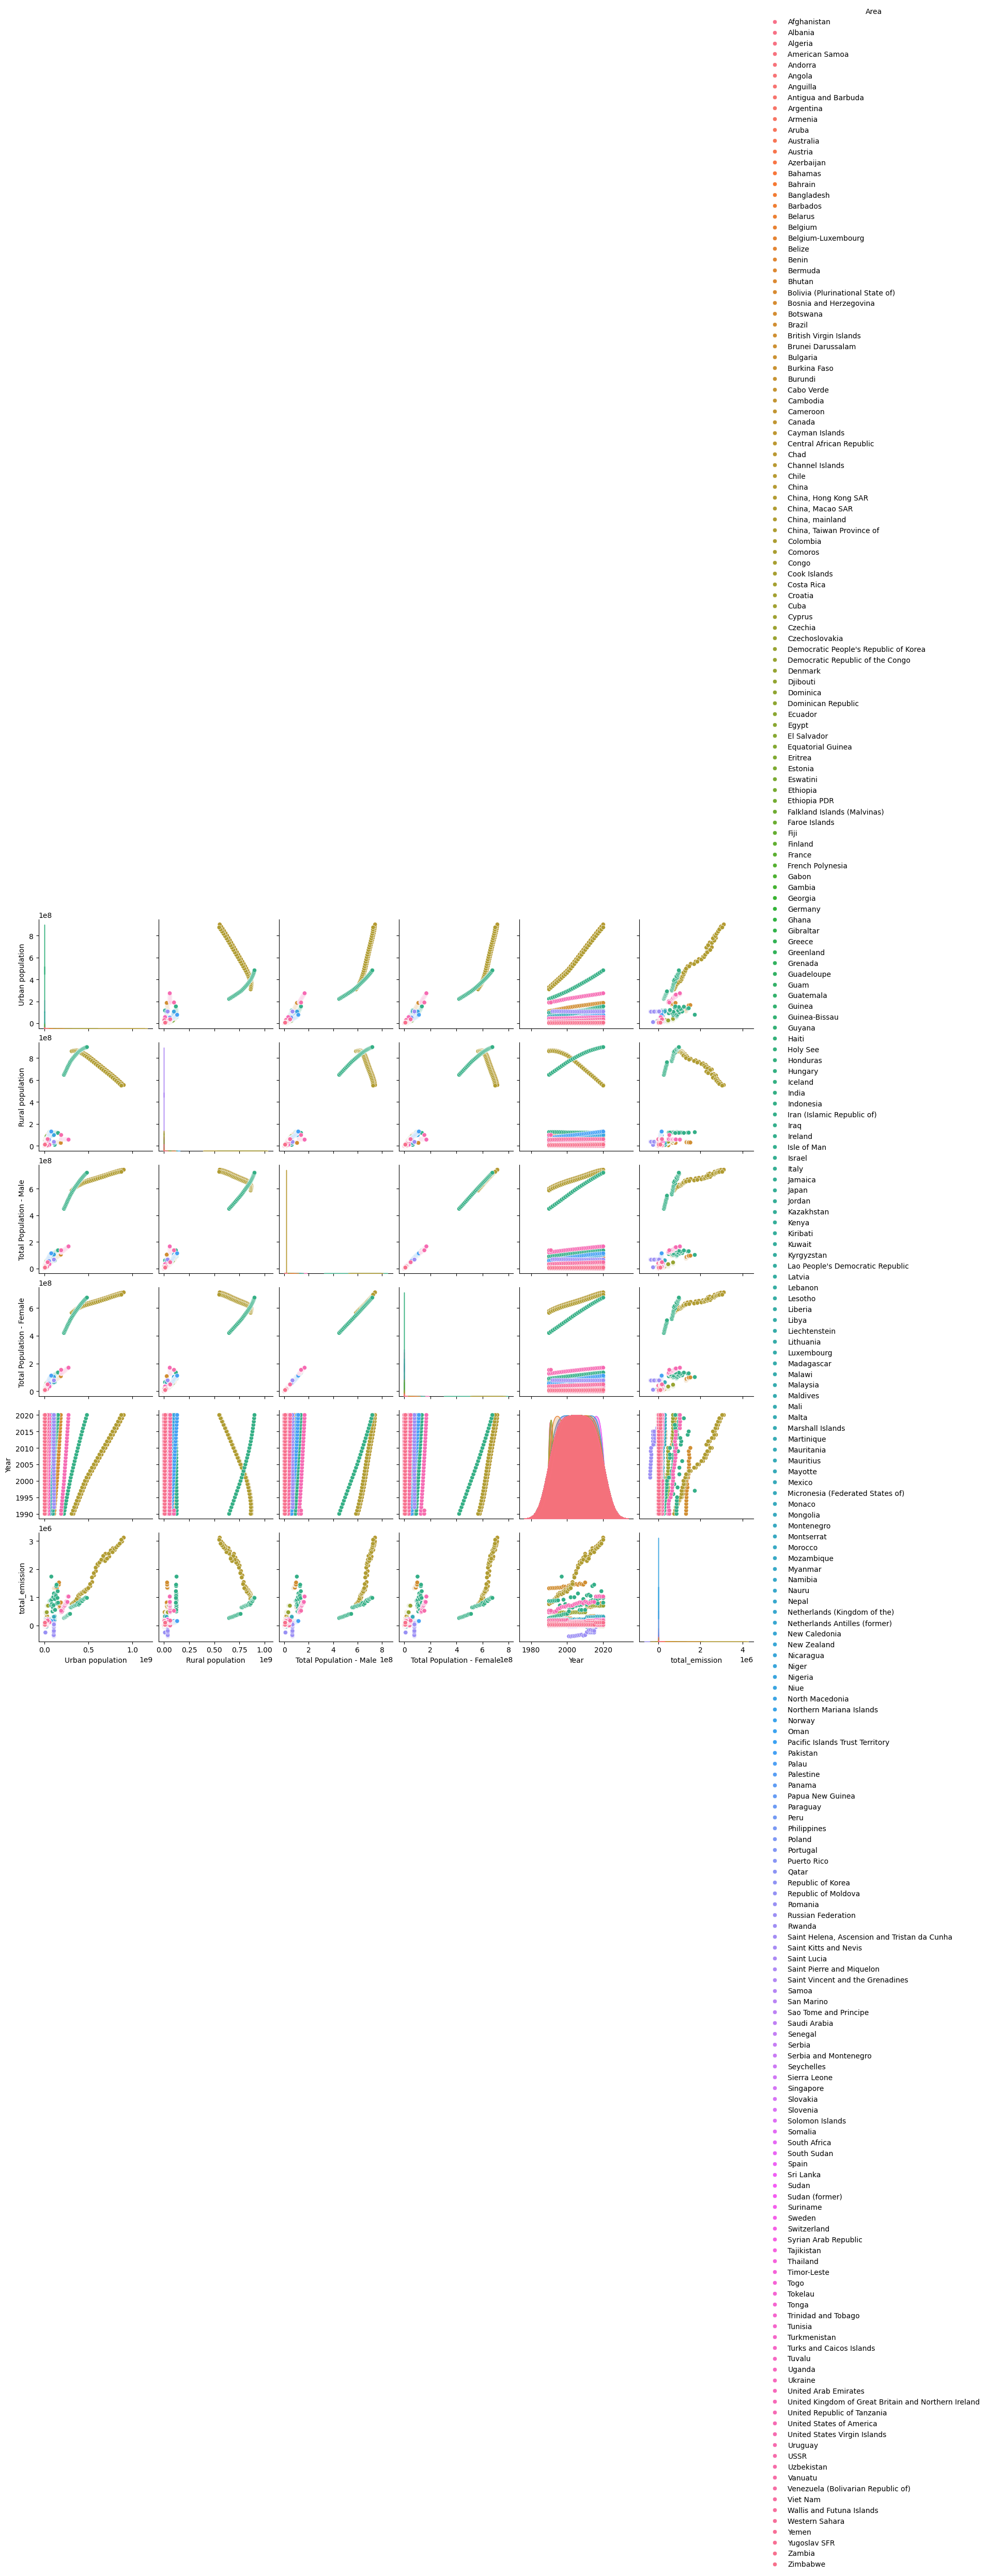

In [7]:
sns.pairplot(df[["Area", "Urban population", "Rural population", "Total Population - Male", "Total Population - Female", 'Year', "total_emission"]], hue="Area")

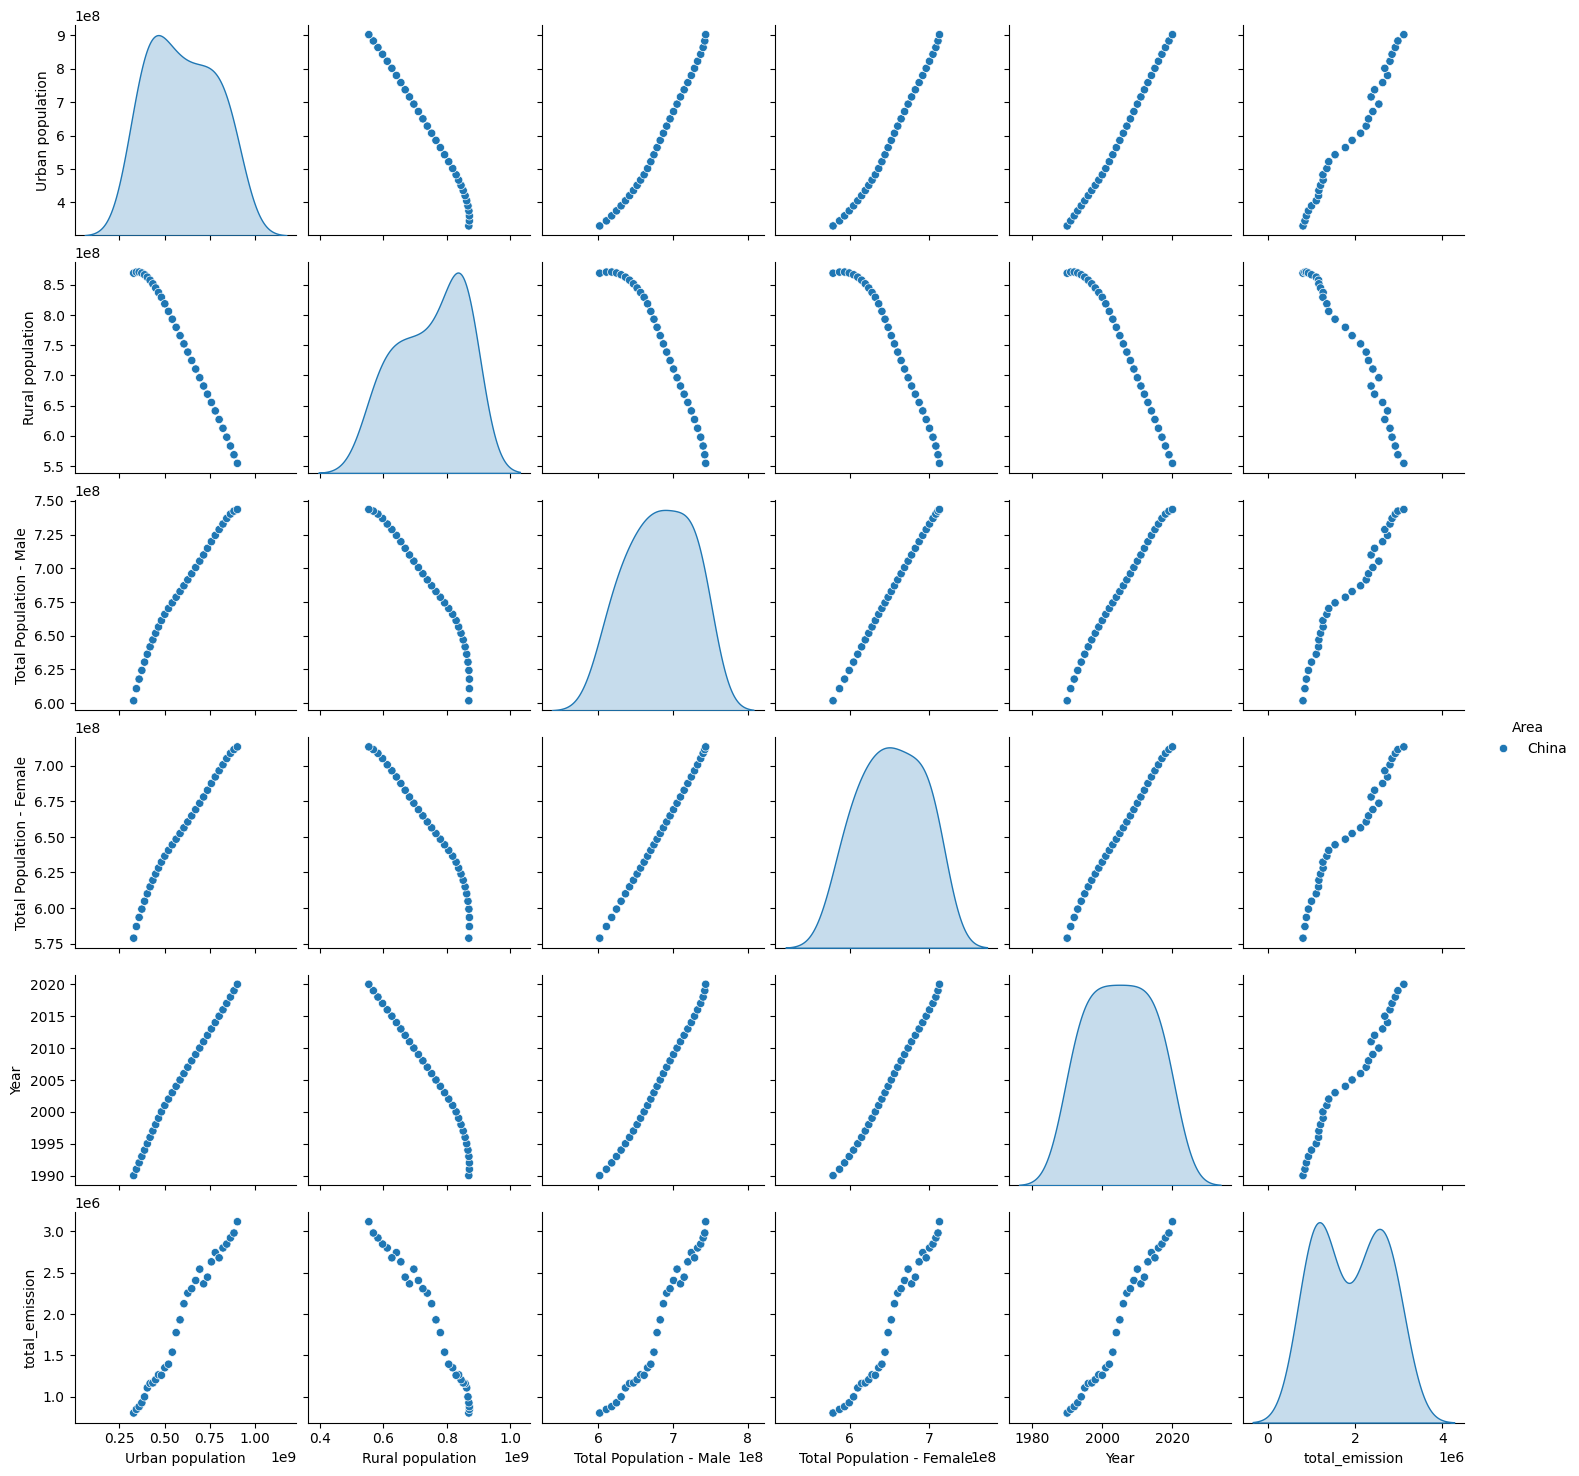

In [8]:
df_china = df[df["Area"] == "China"]

sns.pairplot(df_china[["Area", "Urban population", "Rural population", "Total Population - Male", "Total Population - Female", 'Year', "total_emission"]], hue="Area")

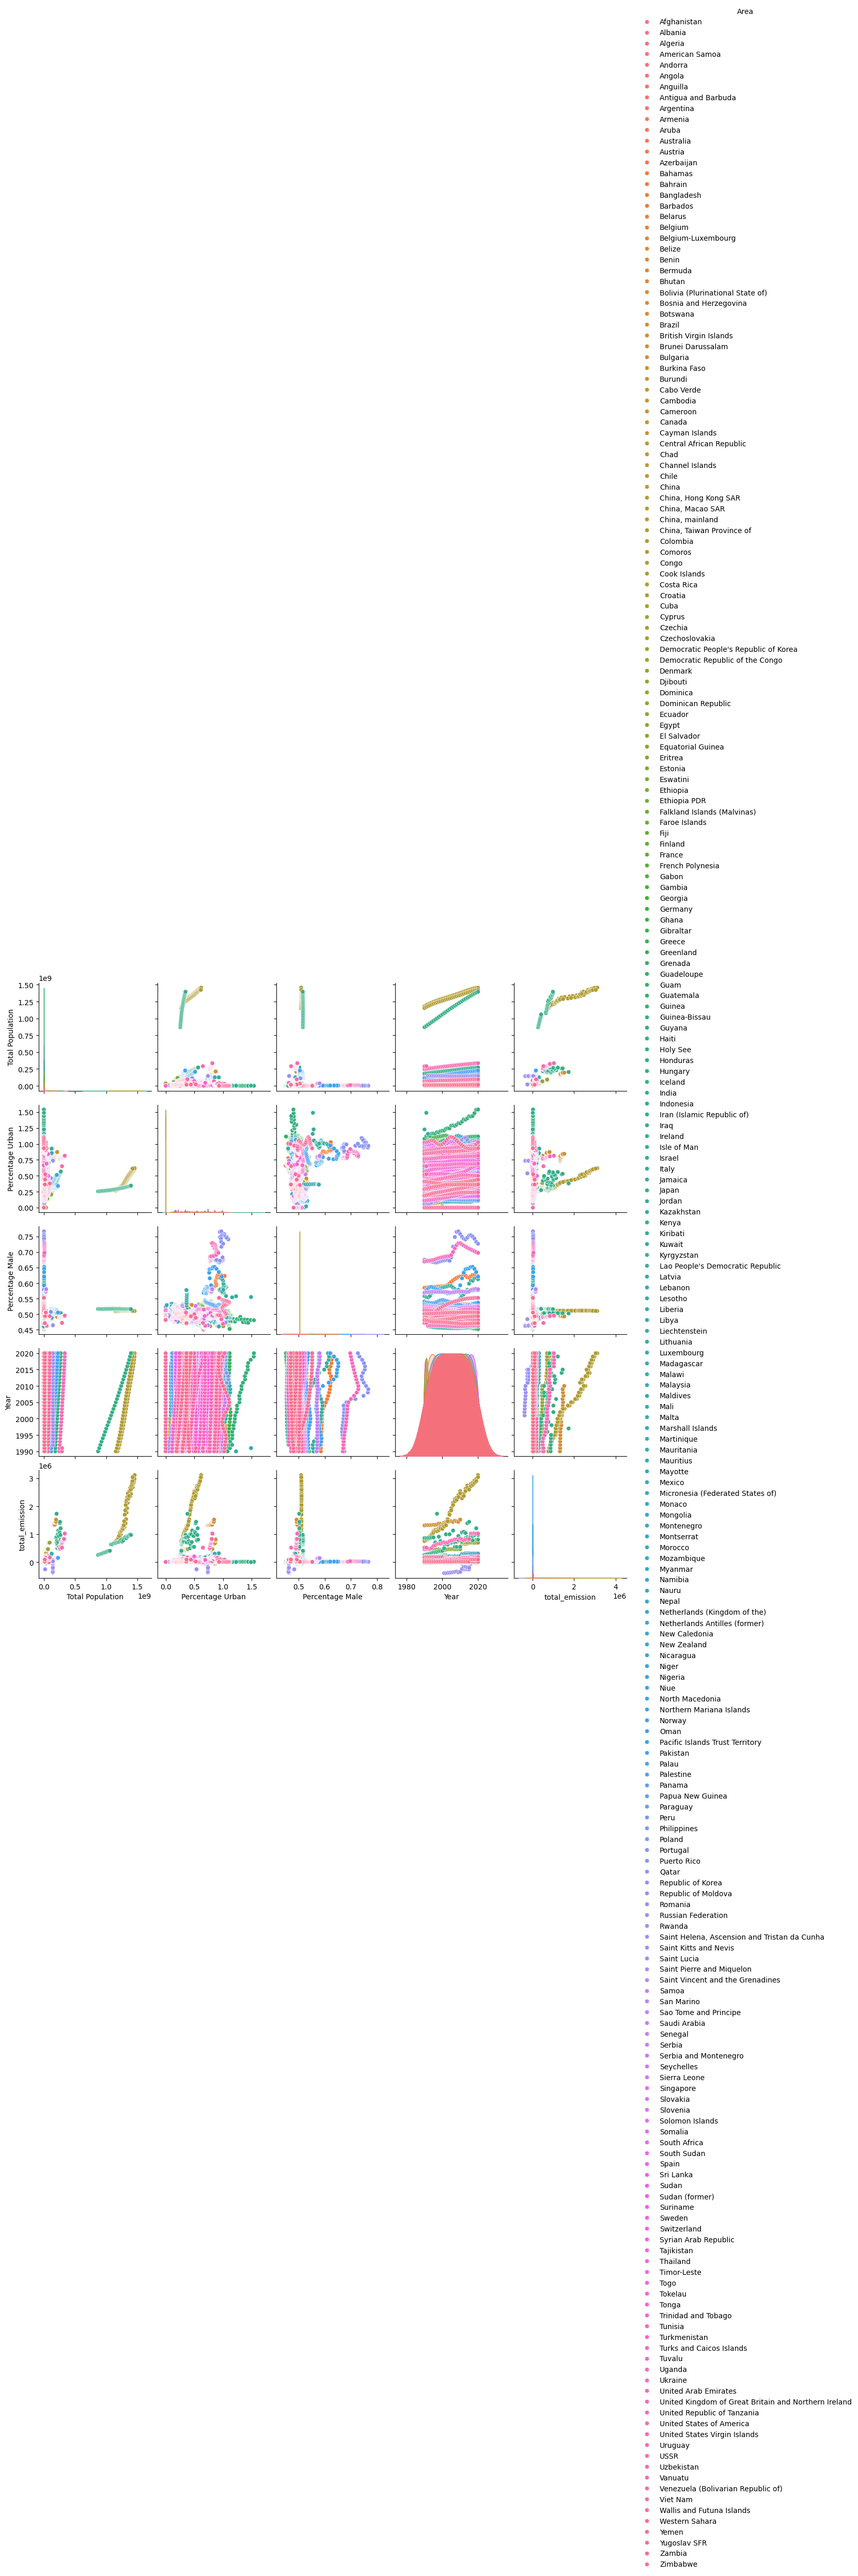

In [9]:
# data preprocessing

df["Total Population"] = df["Total Population - Male"] + df["Total Population - Female"]
df["Percentage Urban"] = df["Urban population"] / df["Total Population"]
df["Percentage Male"] = df["Total Population - Male"] / df["Total Population"]

sns.pairplot(df[["Area", "Total Population", "Percentage Urban", "Percentage Male", 'Year', "total_emission"]], hue="Area")

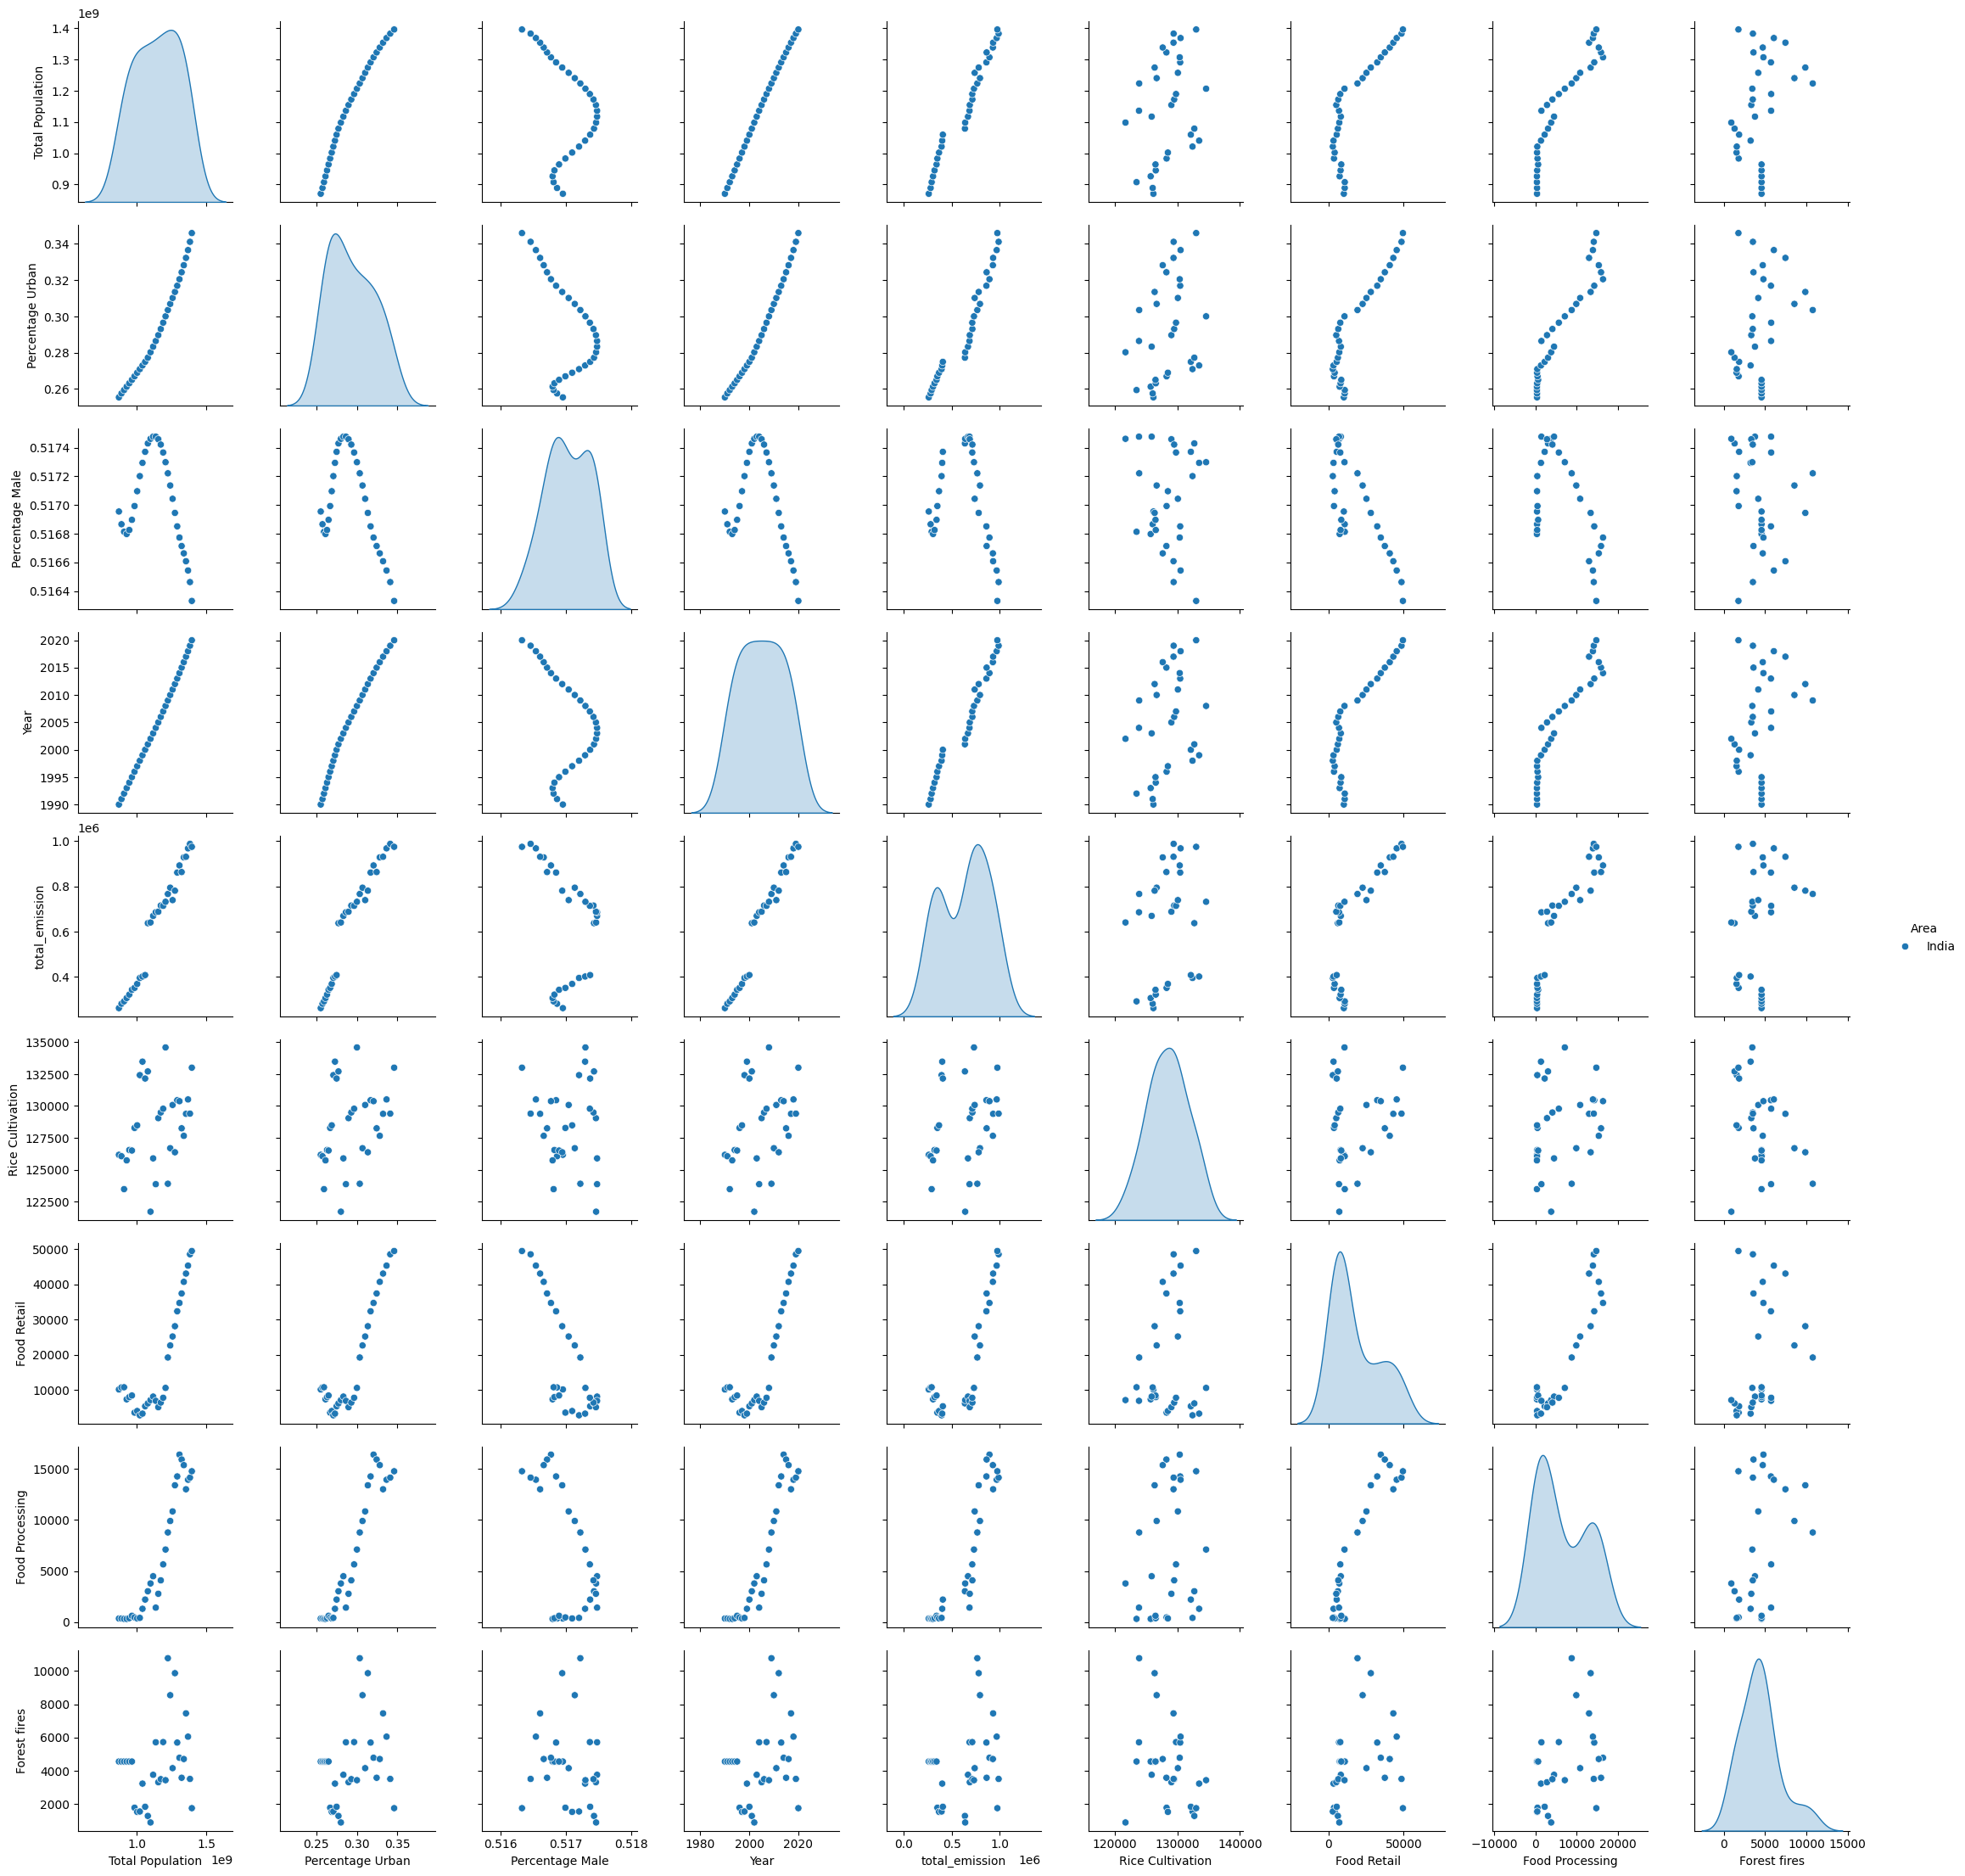

In [11]:
df_china = df[df["Area"] == "India"]

sns.pairplot(df_china[["Area", "Total Population", "Percentage Urban", "Percentage Male", 'Year', "total_emission", "Rice Cultivation", "Food Retail", "Food Processing", "Forest fires"]], hue="Area")

In [ ]:
# import the dataset from csv file
df = pd.read_csv('./data/Agrofood_co2_emission.csv')

# preview the dataset
df.head()


df = df.dropna()

df = df.reset_index(drop=True)

df.describe()

,Year,Savanna fires,Forest fires,Crop Residues,Rice Cultivation,Drained organic soils (CO2),Pesticides Manufacturing,Food Transport,Forestland,Net Forest conversion,...,Manure Management,Fires in organic soils,Fires in humid tropical forests,On-farm energy use,Rural population,Urban population,Total Population - Male,Total Population - Female,total_emission,Average Temperature °C
count,4546.000000,4546.000000,4546.000000,4546.000000,4546.000000,4546.000000,4546.000000,4546.000000,4546.000000,4.546000e+03,...,4546.000000,4546.000000,4546.000000,4546.000000,4.546000e+03,4.546000e+03,4.546000e+03,4.546000e+03,4.546000e+03,4546.000000
mean,2005.298724,1578.318742,1154.424220,1202.174505,5601.932066,5274.474704,490.486595,2706.917010,-25260.695489,2.096907e+04,...,2938.618438,1854.341985,778.154170,3949.355305,2.635997e+07,2.483675e+07,2.579152e+07,2.538586e+07,8.787338e+04,0.912381
std,8.859797,6188.105460,3788.977297,4069.987071,21612.516836,19388.814454,1747.779191,6754.799901,96669.741412,1.145262e+05,...,9089.688421,28040.218491,3111.316439,14403.156282,1.091657e+08,8.018695e+07,9.302138e+07,8.863806e+07,2.759863e+05,0.580555
min,1990.000000,0.000000,0.000000,0.004500,0.000000,0.000000,0.000000,1.054300,-797183.079000,0.000000e+00,...,0.570700,0.000000,0.000000,0.031900,2.050600e+04,2.307800e+04,3.405900e+04,3.402500e+04,-3.918841e+05,-1.302417
25%,1998.000000,0.334500,0.048400,23.357000,90.361875,0.000000,8.000000,98.830450,-7498.135150,0.000000e+00,...,101.040225,0.000000,0.000000,43.269850,9.617765e+05,1.533926e+06,1.580942e+06,1.638107e+06,6.147423e+03,0.526979
50%,2005.000000,11.354550,7.592600,132.518200,268.512150,149.762750,34.000000,411.583700,-424.181900,4.548745e+02,...,445.150650,0.000000,0.000000,362.908800,3.552274e+06,4.496411e+06,4.673897e+06,4.776540e+06,1.792552e+04,0.875167
75%,2013.000000,329.383700,222.426075,513.156025,1344.480125,2864.212500,189.750000,1654.717400,0.000000,7.459780e+03,...,1699.477000,0.000000,65.823275,1733.715400,1.175335e+07,1.490217e+07,1.452794e+07,1.464379e+07,7.299027e+04,1.262063
max,2020.000000,114616.401100,52227.630600,33490.074100,164915.255600,241025.069600,16459.000000,67945.765000,171121.076000,1.605106e+06,...,70592.646500,991717.543100,51771.256800,248879.176900,9.000991e+08,9.020778e+08,7.435866e+08,7.133419e+08,3.115114e+06,3.558083


In [ ]:
# list the number of areas in the dataset

underdeveloped_countries = ["Bangladesh", "Haiti", "Timor-Leste", "Myanmar", "Cambodia"]

developing_countries = ["China", "India", "Viet Nam", "Indonesia", "Malaysia"]

developed_countries = ["United States of America", "Germany", "Japan", "France", "Republic of Korea"]


unique_areas = [*underdeveloped_countries, *developing_countries, *developed_countries]

"""
Savanna fires: Emissions from fires in savanna ecosystems.
Forest fires: Emissions from fires in forested areas.
Crop Residues: Emissions from burning or decomposing leftover plant material after crop harvesting.
Rice Cultivation: Emissions from methane released during rice cultivation.
Drained organic soils (CO2): Emissions from carbon dioxide released when draining organic soils.
Pesticides Manufacturing: Emissions from the production of pesticides.
Food Transport: Emissions from transporting food products.
Forestland: Land covered by forests.
Net Forest conversion: Change in forest area due to deforestation and afforestation.
Food Household Consumption: Emissions from food consumption at the household level.
Food Retail: Emissions from the operation of retail establishments selling food.
On-farm Electricity Use: Electricity consumption on farms.
Food Packaging: Emissions from the production and disposal of food packaging materials.
Agrifood Systems Waste Disposal: Emissions from waste disposal in the agrifood system.
Food Processing: Emissions from processing food products.
Fertilizers Manufacturing: Emissions from the production of fertilizers.
IPPU: Emissions from industrial processes and product use.
Manure applied to Soils: Emissions from applying animal manure to agricultural soils.
Manure left on Pasture: Emissions from animal manure on pasture or grazing land.
Manure Management: Emissions from managing and treating animal manure.
Fires in organic soils: Emissions from fires in organic soils.
Fires in humid tropical forests: Emissions from fires in humid tropical forests.
"""

target_variables = [
    "Savanna fires",
    "Forest fires",
    "Crop Residues",
    "Rice Cultivation",
    "Drained organic soils (CO2)",
    "Pesticides Manufacturing",
    "Food Transport",
    "Forestland",
    "Net Forest conversion",
    "Food Household Consumption",
    "Food Retail",
    "On-farm Electricity Use",
    "Food Packaging",
    "Agrifood Systems Waste Disposal",
    "Food Processing",
    "Fertilizers Manufacturing",
    "IPPU",
    "Manure applied to Soils",
    "Manure left on Pasture",
    "Manure Management",
    "Fires in organic soils",
    "total_emission"
]


# create a dictionary to store the regressor objects

areas = {}

# create a regressor object for each area
for area in unique_areas:
    regressors = {}
    for target in target_variables:
        this_df = df[df["Area"] == area]
        regressor = Regressor(this_df, ["Total Population", "Percentage Urban"],[target])
        regressor.fit()
        regressor.score()
        regressors[target] = regressor
    areas[area] = regressors



NameError: name 'df' is not defined

In [ ]:
areas["India"]["Food Retail"].mape

np.float64(0.3265774581497712)

In [ ]:
targetsregressors = areas["India"]

area_mape_map = {area: regressors[area].mape for area in regressors}

# sort by lowest MAPE

sorted_area_mape_map = dict(sorted(area_mape_map.items(), key=lambda item: item[1]))

sorted_area_mape_map

{'Forestland': np.float64(-1.3237240855870873),
 'Drained organic soils (CO2)': np.float64(0.0018150066123054512),
 'Agrifood Systems Waste Disposal': np.float64(0.003690063337733222),
 'Manure Management': np.float64(0.007322512761257273),
 'Manure applied to Soils': np.float64(0.009835740166242895),
 'Manure left on Pasture': np.float64(0.011431636283610309),
 'Rice Cultivation': np.float64(0.018477831165965766),
 'IPPU': np.float64(0.026012653592100327),
 'Crop Residues': np.float64(0.037810294837724384),
 'Food Household Consumption': np.float64(0.04617417007080624),
 'total_emission': np.float64(0.05348956017103851),
 'Fertilizers Manufacturing': np.float64(0.056655849744476315),
 'On-farm Electricity Use': np.float64(0.10360951145147511),
 'Pesticides Manufacturing': np.float64(0.19115038960391886),
 'Food Packaging': np.float64(0.21011973129195502),
 'Forest fires': np.float64(0.27206476311164646),
 'Savanna fires': np.float64(0.30944495886700224),
 'Food Retail': np.float64(0.3

In [ ]:
area_rural_effect_map = {area: regressors[area].beta[2] for area in regressors}

sorted_area_rural_effect_map = dict(sorted(area_rural_effect_map.items(), key=lambda item: item[1]))

sorted_area_rural_effect_map

{'Forestland': array([-114347.07169652]),
 'Net Forest conversion': array([-31953.84053651]),
 'Fertilizers Manufacturing': array([-5186.02651622]),
 'Agrifood Systems Waste Disposal': array([-2781.38072]),
 'Rice Cultivation': array([-2196.70185509]),
 'Drained organic soils (CO2)': array([-30.17122485]),
 'Fires in organic soils': array([0.]),
 'Savanna fires': array([119.84037914]),
 'Manure Management': array([124.92551433]),
 'Manure applied to Soils': array([218.80636193]),
 'Food Packaging': array([605.17910732]),
 'Pesticides Manufacturing': array([636.74335655]),
 'total_emission': array([988.82729662]),
 'Forest fires': array([1343.9162198]),
 'Manure left on Pasture': array([1674.20873922]),
 'Crop Residues': array([1952.43848396]),
 'Food Transport': array([2698.99306188]),
 'Food Processing': array([5119.4922033]),
 'Food Household Consumption': array([28670.09434498]),
 'Food Retail': array([38487.68324083]),
 'On-farm Electricity Use': array([49720.12261176]),
 'IPPU': a

In [ ]:
# remove values with no mape
areas_json = {
    area: {
        target: {
            "mape": targetsregressors[target].mape,
            "beta": targetsregressors[target].beta.tolist(),
            "means": targetsregressors[target].means.tolist(),
            "stds": targetsregressors[target].stds.tolist()
        }
        for target in targetsregressors if targetsregressors[target].mape > 0 and targetsregressors[target].mape < 1
    } for area, targetsregressors in areas.items()
}

# export the area json map to a json file

import json

with open('targets_json_map.json', 'w') as f:
    json.dump(areas_json, f)